# Language Identification Model


In [1]:
### TO DEBUGGIN'
_DEBUG = True

## Load Package

In [2]:
# to load and manipulate data
import pandas as pd
import numpy as np
import os
import json
from sklearn.model_selection import train_test_split

# to make neural netowrk model, sequencing and tokenizing
import tensorflow as tf

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import layers

# to evaluate and display results
from sklearn.metrics import  confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt

ModuleNotFoundError: No module named 'tensorflow'

In [3]:
import squarify

## Load Data

In [3]:
## print paths
for root, dirs, files in os.walk('./data'):
    for filename in files:
        print(os.path.join(root,filename))

In [4]:
%%time
## vamos a medir el TIME de esta shit

df = pd.read_csv("./data/sentences.csv")

FileNotFoundError: [Errno 2] No such file or directory: './data/sentences.csv'

## Data Cleansing

In [6]:
## eliminar columna maldita que esta de mas ID
df.drop(columns=['id'],inplace=True)

In [7]:
df.head()

,lan_code,sentence
0,cmn,我們試試看！
1,cmn,我该去睡觉了。
2,cmn,你在干什麼啊？
3,cmn,這是什麼啊？
4,cmn,今天是６月１８号，也是Muiriel的生日！


In [8]:
## [x] no hay sentencias sin code - :D!
if _DEBUG:
    display(df.describe())

,lan_code,sentence
count,10341812,10341812
unique,404,10330761
top,eng,Bravo!
freq,1586621,11


Code LANGUAGE with less frequency than 10: sentence    277
dtype: int64


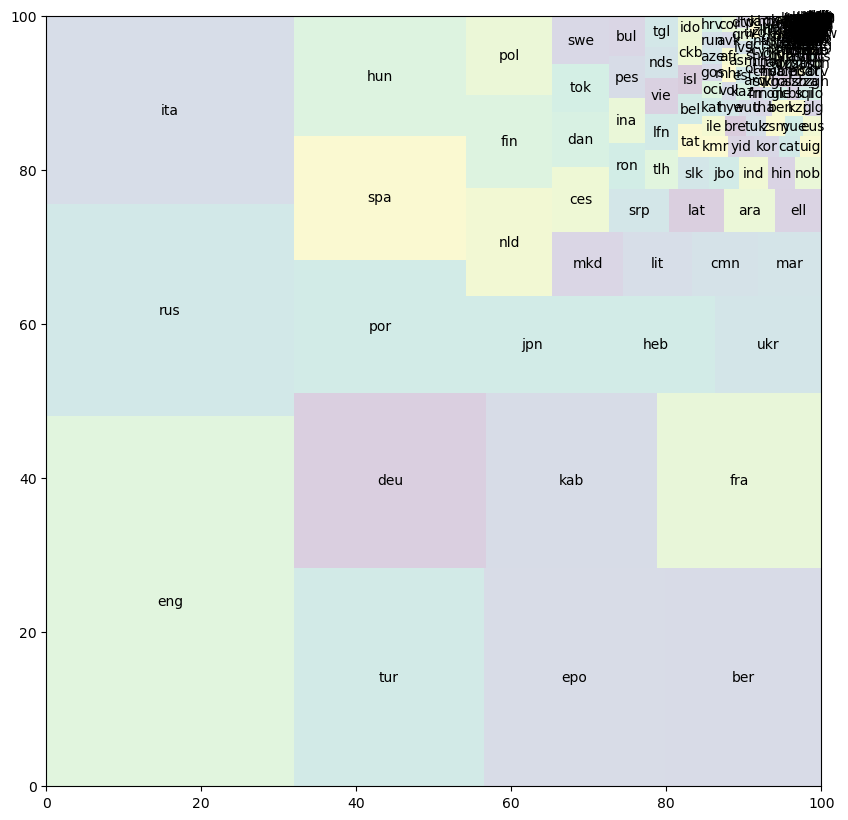

In [9]:
if _DEBUG:
    df_exploration = df.groupby("lan_code").count().sort_values("sentence",ascending = False)

    #!# posiblemente cuando se entrene el modelo los de baja frecuencia no va a predecir correctamente
    #!# como posible opcion 1 analizar con todo y luego ver el impacto de remover esos code lan con freq 1
    
    count_freq_1 = df_exploration[df_exploration.sentence<=10].sum()
    print("Code LANGUAGE with less frequency than 10: {}".format(count_freq_1))
    
    ## GRAPH - TREEMAP
    sizes_treemap = df_exploration["sentence"].tolist()
    labels_treemap = df_exploration.index.values.tolist()
    
    plt.figure(figsize=(10,10))
    squarify.plot(sizes = sizes_treemap, label = labels_treemap, alpha=0.2)
    plt.show()
    
    del df_exploration

## Preprocessing Data - FULL dataset sentences

In [10]:
# ENCODING CLASSES (cod language)
classes_list = list(df.lan_code.unique())
print("Count of Classes: {}".format(len(classes_list)))

Count of Classes: 404


In [11]:
## crearemos dos dic para usos posteriores de transformacion

cls_to_num = {
    cls : i
    for i,cls in enumerate(classes_list)
}

num_to_cls = {
    i : cls
    for cls,i in cls_to_num.items()
}

In [12]:
## cambiar el string-code por int-code para ingresarlos al modelo

display(df.head())
df.lan_code = df.lan_code.map(cls_to_num).astype(int)
display(df.head())

,lan_code,sentence
0,cmn,我們試試看！
1,cmn,我该去睡觉了。
2,cmn,你在干什麼啊？
3,cmn,這是什麼啊？
4,cmn,今天是６月１８号，也是Muiriel的生日！


,lan_code,sentence
0,0,我們試試看！
1,0,我该去睡觉了。
2,0,你在干什麼啊？
3,0,這是什麼啊？
4,0,今天是６月１８号，也是Muiriel的生日！


## Subset Train & Test

In [13]:
# Lista de Sentencias
X = df.pop('sentence').values

# Lista de CODE LAN 
y = df.copy().values.T[0]

if _DEBUG:
    display(X)
    display(y)

array(['我們試試看！', '我该去睡觉了。', '你在干什麼啊？', ..., 'Los botaron.',
       'Los hicieron correr.', 'Los corrieron.'], dtype=object)

array([0, 0, 0, ..., 6, 6, 6])

In [14]:
## liberamos memoria virtual (RAM)
del df

In [15]:
X_train, X_test, y_train, y_test = train_test_split(
    X,y,
    train_size=0.8,
    random_state=50,
    shuffle = True
)

## liberamos memoria virtual (RAM)
del X, y

# Tokenization

Usaremos este metodo para procesar los datos input para el modelo:

mas info: https://towardsdatascience.com/tokenization-for-natural-language-processing-a179a891bad4


### Sentencias -> Secuencias de palabras


In [17]:
## parametros

NUM_WORDS = 1000000
MAX_LEN = 100
NUM_CLASSES = 404 # esto lo sacamos de arriba

In [18]:
def tokenize_and_sequence(
                            train_sentences,
                            test_sentences
                            ):
    tok = Tokenizer(num_words = NUM_WORDS, oov_token='<OOV>')
    tok.fit_on_texts(train_sentences)
    
    # training set
    train_seq = tok.texts_to_sequences(train_sentences)
    train_seq = pad_sequences(
                    train_seq,
                    padding = 'post',
                    maxlen = MAX_LEN,
                    truncating = 'post'
                )
    
    # testing set
    test_seq = tok.texts_to_sequences(test_sentences)
    test_seq = pad_sequences(
                    test_seq,
                    padding = 'post',
                    maxlen = MAX_LEN,
                    truncating = 'post'
                )
    if _DEBUG:
        print(tok.get_config())
    
    return train_seq, test_seq, tok

In [19]:
%%time
## call function 
X_train, X_test, tok = tokenize_and_sequence(X_train, X_test)

# WARNING: problemas de tiempo de respuesta, se debe cambiar la config del notebook

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [20]:
if _DEBUG:
    print(X_train.shape)
    print(X_test.shape)

(8273449, 100)
(2068363, 100)


# Model NLP

## Build Model

- Embedding layer son capas de palabras previamente entrenadas como GloVe, se usan mucho en NLP.
- LSTM : capa de memoria a largo plazo
- Dense: capa densa conectada normal
- Dropout: ayuda a evitar el sobreajuste en la entrada

Funciones de Activacion: https://towardsdatascience.com/7-popular-activation-functions-you-should-know-in-deep-learning-and-how-to-use-them-with-keras-and-27b4d838dfe6

Ocupamos:
- ReLu
- Softmax: se usa muy amenudo en la ultima capa de la red, como FA. dado que el resultado se podria interpretar como una D. P. 

In [21]:
## heredamos la clases tf.keras.model (Classic)
class NLPModel(tf.keras.Model):
    def __init__(self,
                vocad_dim = NUM_WORDS,
                max_len = MAX_LEN,
                num_classes = NUM_CLASSES):
        super().__init__()
        
        self.embedding = layers.Embedding(input_dim = vocad_dim, output_dim = 32, input_length = max_len)
        
        self.lstm1 = layers.Bidirectional(layers.LSTM(units = 32, return_sequences=True))
        self.lstm2 = layers.Bidirectional(layers.LSTM(16))
        
        self.dense = layers.Dense(64, activation = 'relu')
        
        self.dropout = layers.Dropout(0.5)
        
        self.classifier = layers.Dense(num_classes, activation = 'softmax')
        
    def call(self, inputs, training = False):
        x = self.embedding(inputs)
        x = self.lstm1(x)
        x = self.lstm2(x)
        x = self.dense(x)
        if training:
            x = self.dropout(x, training = training)
        return self.classifier(x)

In [22]:
model = NLPModel()

In [23]:
## Especificamos la configuración de entrenamiento (optimizador, pérdida, métricas):
# uso de ADAM Algorithm

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy']
)

## Train Model

In [24]:
%%time
history = model.fit(
                    X_train, y_train,
                    validation_data=(X_test, y_test),
                    batch_size=512, 
                    epochs=5
)

Epoch 1/5


2022-10-01 22:26:57.310947: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


16160/16160 [==============================] - 4820s 298ms/step - loss: 0.4472 - accuracy: 0.8864 - val_loss: 0.1603 - val_accuracy: 0.9572
Epoch 2/5
16160/16160 [==============================] - 10169s 629ms/step - loss: 0.1468 - accuracy: 0.9615 - val_loss: 0.1306 - val_accuracy: 0.9655
Epoch 3/5
16160/16160 [==============================] - 4874s 302ms/step - loss: 0.1130 - accuracy: 0.9696 - val_loss: 0.1226 - val_accuracy: 0.9674
Epoch 4/5
16160/16160 [==============================] - 4862s 301ms/step - loss: 0.0979 - accuracy: 0.9735 - val_loss: 0.1205 - val_accuracy: 0.9692
Epoch 5/5
16160/16160 [==============================] - 4918s 304ms/step - loss: 0.0890 - accuracy: 0.9756 - val_loss: 0.1193 - val_accuracy: 0.9697
CPU times: user 13h 57min 19s, sys: 8h 6min 48s, total: 22h 4min 8s
Wall time: 8h 14min 4s


In [25]:
## datos del entrenamiento
history.history

{'loss': [0.44724756479263306,
  0.1468258649110794,
  0.11304166913032532,
  0.0978599488735199,
  0.08898536115884781],
 'accuracy': [0.886440098285675,
  0.96149080991745,
  0.9696206450462341,
  0.973475992679596,
  0.9756453633308411],
 'val_loss': [0.16031499207019806,
  0.1306367963552475,
  0.12264436483383179,
  0.1205485463142395,
  0.11928495764732361],
 'val_accuracy': [0.9571723937988281,
  0.9654504656791687,
  0.9674201011657715,
  0.9691606163978577,
  0.9696919918060303]}

## Evaluate Model

In [26]:
%%time
y_pred = model.predict(X_test, batch_size=512, verbose=1)
y_pred = y_pred.argmax(axis=1)

4040/4040 [==============================] - 261s 65ms/step
CPU times: user 8min 51s, sys: 3min 20s, total: 12min 12s
Wall time: 4min 25s


In [27]:
%%time
acc = accuracy_score(y_test, y_pred)
conf_mat = confusion_matrix(y_test, y_pred)
conf_mat_recall = confusion_matrix(y_test, y_pred, normalize='true')
conf_mat_precision = confusion_matrix(y_test, y_pred, normalize='pred')

CPU times: user 2.33 s, sys: 74.9 ms, total: 2.4 s
Wall time: 2.4 s


### Accuracy

In [28]:
print(f"Accuracy = {acc:.2%}")

Accuracy = 96.97%


In [99]:
def app(phrase, _DEBUG = _DEBUG):
    phrase_seq = tok.texts_to_sequences(phrase)
    phrase_seq = pad_sequences(
                    phrase_seq,
                    padding = 'post',
                    maxlen = MAX_LEN,
                    truncating = 'post'
                )
    if _DEBUG :
        print(phrase_seq)
    
    output = model.predict(phrase_seq, batch_size=512, verbose=1)
    list_results = {}
    for i in range(len(output[0])):
        if output[0][i]>=0.1:
            list_results[num_to_cls[i]] = output[0][i]

    return list_results, output

# Anexo: confusion matrix

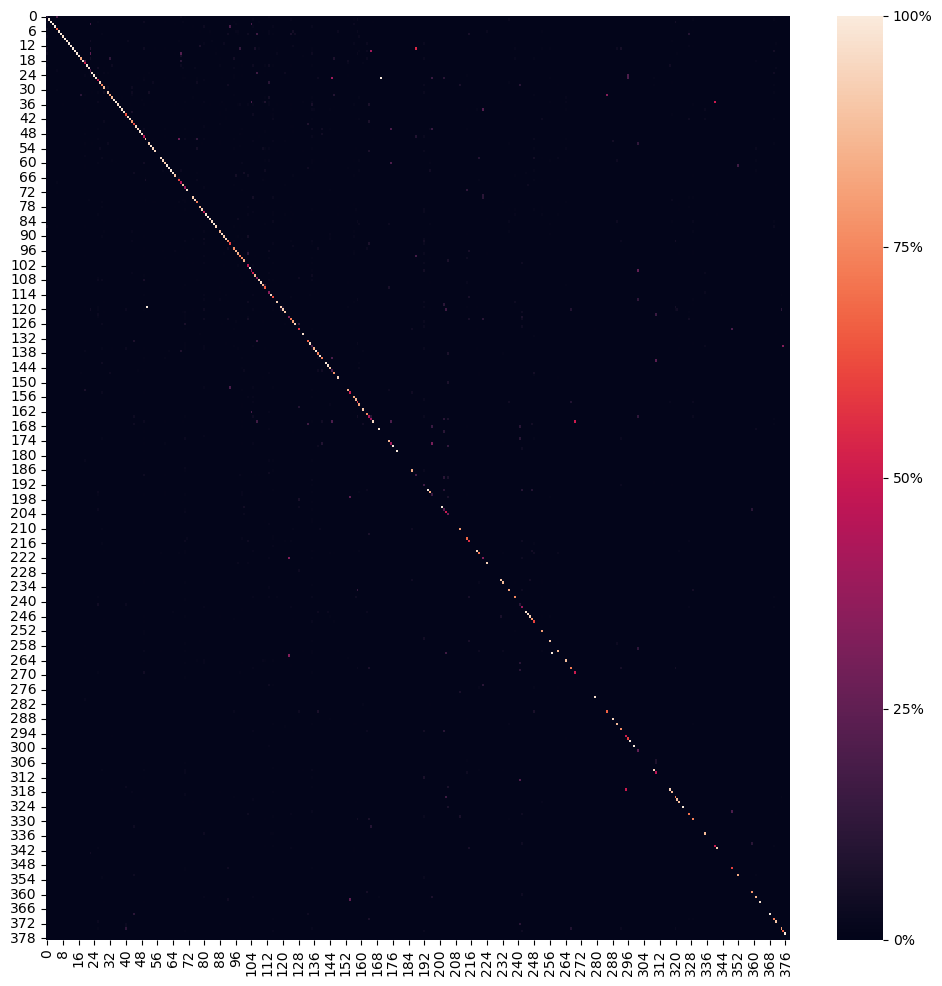

In [29]:
plt.figure(figsize=(12, 12))
ax = sns.heatmap(conf_mat_precision, vmin=0, vmax=1)
cbar = ax.collections[0].colorbar
cbar.set_ticks([0, .25, 0.5, .75, 1])
cbar.set_ticklabels(['0%', '25%', '50%', '75%', '100%'])
plt.show()

# Prueba de APP


In [106]:
phrase = "habia una vez una persona sentada"
result, output = app(phrase)


[[11396     0     0 ...     0     0     0]
 [    3     0     0 ...     0     0     0]
 [ 5704     0     0 ...     0     0     0]
 ...
 [    3     0     0 ...     0     0     0]
 [    9     0     0 ...     0     0     0]
 [    3     0     0 ...     0     0     0]]
1/1 [==============================] - 0s 23ms/step


In [107]:
import operator
print(sorted(result.items(), key=operator.itemgetter(1), reverse=True))

[('eng', 0.34160417), ('deu', 0.10362743), ('fin', 0.10270908)]


In [105]:
with open("./data/language.json") as f:
    lan_to_language = json.load(f)
display(lan_to_language['kab'])

'Kabyle'